Dataset: https://www.kaggle.com/datasets/loulouashley/nhsadmissions-and-gp-referrals

Data Source: Quarterly Hospital Activity Data (https://www.england.nhs.uk/statistics/statistical-work-areas/hospital-activity/quarterly-hospital-activity/qar-data/)

Kaggle original: https://www.kaggle.com/code/loulouashley/nhs-time-series-study-admissions-gp-referrals

<< A random practice >>

# NHS Admissions and GP referrals

Type: Time series analysis

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime

%matplotlib inline  
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import itertools


In [64]:
df = pd.read_excel("NHS-Admissions.xls")

In [70]:
# Checking % of missing values in columns
def check_missing_values(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [65]:
df.head(5)

,Year,Month,Day,Specialty Code,Specialty Name,Decisions to Admit,Admissions,Failed to Attend,Removals,Deferred admissions,Patients Suspended,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA
0,2008,6,1,C_999,Total,1182425,1063433,23595,157446,43986,44532,2655581.000,1.462796e+06,3661937,343937,7854773,1000206
1,2008,9,1,C_999,Total,1199964,1087367,25920,156115,45368,42254,2643823.264,1.463597e+06,3731940,365462,7883778,1017999
2,2008,12,1,C_999,Total,1217895,1094776,25081,164242,50124,52006,2552289.424,1.470639e+06,3775186,368552,7969423,1021504
3,2008,3,1,C_999,Total,1229108,1116562,25313,163881,43875,38526,2716094.000,1.512271e+06,3784347,352345,8100045,1051220
4,2009,6,1,C_999,Total,1250250,1105491,24984,159466,42671,43105,2808565.000,1.560909e+06,3945308,367391,8195380,1007916


In [66]:
df.shape

(48, 17)

There are 48 records(rows) and 17 cols in this dataset. 

In [67]:
# combining Year, Month and Day varialbes as a new date variable
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors = 'coerce')
df = df.sort_values(by = 'Date', ascending = True)

In [68]:
# drop the unnecessary columns
df = df.drop(['Year','Month', 'Day'], axis = 1) 

In [69]:
df.head(5)

,Specialty Code,Specialty Name,Decisions to Admit,Admissions,Failed to Attend,Removals,Deferred admissions,Patients Suspended,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA,Date
3,C_999,Total,1229108,1116562,25313,163881,43875,38526,2716094.000,1.512271e+06,3784347,352345,8100045,1051220,2008-03-01
0,C_999,Total,1182425,1063433,23595,157446,43986,44532,2655581.000,1.462796e+06,3661937,343937,7854773,1000206,2008-06-01
1,C_999,Total,1199964,1087367,25920,156115,45368,42254,2643823.264,1.463597e+06,3731940,365462,7883778,1017999,2008-09-01
2,C_999,Total,1217895,1094776,25081,164242,50124,52006,2552289.424,1.470639e+06,3775186,368552,7969423,1021504,2008-12-01
7,C_999,Total,1290450,1168811,25957,181311,46660,39622,2788045.000,1.564183e+06,4021017,390378,8605578,1083132,2009-03-01


In [71]:
check_missing_values(df)

Specialty Code - 0%
Specialty Name - 0%
Decisions to Admit - 0%
Admissions - 0%
Failed to Attend - 0%
Removals - 0%
Deferred admissions - 0%
Patients Suspended  - 0%
GP Referrals Made - 0%
Other Referrals Made - 0%
First Attendances Seen - 0%
First Attendances DNA - 0%
Subsequent Attendances Seen - 0%
Subsequent Attendances DNA - 0%
Date - 0%


In [72]:
# checking the data types
df.dtypes

Specialty Code                         object
Specialty Name                         object
Decisions to Admit                      int64
Admissions                              int64
Failed to Attend                        int64
Removals                                int64
Deferred admissions                    object
Patients Suspended                     object
GP Referrals Made                     float64
Other Referrals Made                  float64
First Attendances Seen                  int64
First Attendances DNA                   int64
Subsequent Attendances Seen             int64
Subsequent Attendances DNA              int64
Date                           datetime64[ns]
dtype: object

In [73]:
# checking zero values in each variable
(df == 0).sum()

Specialty Code                  0
Specialty Name                  0
Decisions to Admit              0
Admissions                      0
Failed to Attend                0
Removals                        0
Deferred admissions            39
Patients Suspended             39
GP Referrals Made               0
Other Referrals Made            0
First Attendances Seen          0
First Attendances DNA           0
Subsequent Attendances Seen     0
Subsequent Attendances DNA      0
Date                            0
dtype: int64

In Deferred admissions and Patients Suspended columns, there are 39 rows(among 48 in total) with lack of data, so we're going to remove them from future analysis process. 

Further data analysis will perform on Numerical values only, so Specialty Code and Specialty Name columns are also going to drop. 

In [74]:
df_dropped = df.drop(['Patients Suspended ','Deferred admissions', 'Specialty Code', 'Specialty Name'], axis = 1) 

In [75]:
df_dropped.shape

(48, 11)

In [76]:
# cols = list(df_dropped.columns.values)
# changing the order of the columns
df_dropped = df_dropped[['Date', 
 'Decisions to Admit',
 'Admissions',
 'Failed to Attend',
 'Removals',
 'GP Referrals Made',
 'Other Referrals Made',
 'First Attendances Seen',
 'First Attendances DNA',
 'Subsequent Attendances Seen',
 'Subsequent Attendances DNA']]

In [77]:
df_dropped.head(5)

,Date,Decisions to Admit,Admissions,Failed to Attend,Removals,GP Referrals Made,Other Referrals Made,First Attendances Seen,First Attendances DNA,Subsequent Attendances Seen,Subsequent Attendances DNA
3,2008-03-01,1229108,1116562,25313,163881,2716094.000,1.512271e+06,3784347,352345,8100045,1051220
0,2008-06-01,1182425,1063433,23595,157446,2655581.000,1.462796e+06,3661937,343937,7854773,1000206
1,2008-09-01,1199964,1087367,25920,156115,2643823.264,1.463597e+06,3731940,365462,7883778,1017999
2,2008-12-01,1217895,1094776,25081,164242,2552289.424,1.470639e+06,3775186,368552,7969423,1021504
7,2009-03-01,1290450,1168811,25957,181311,2788045.000,1.564183e+06,4021017,390378,8605578,1083132


### Data cleaning is done.

In [79]:
df_dropped['Admissions'].describe()

count    4.800000e+01
mean     1.331726e+06
std      1.274778e+05
min      1.063433e+06
25%      1.254063e+06
50%      1.353638e+06
75%      1.443568e+06
max      1.493892e+06
Name: Admissions, dtype: float64

<AxesSubplot:>

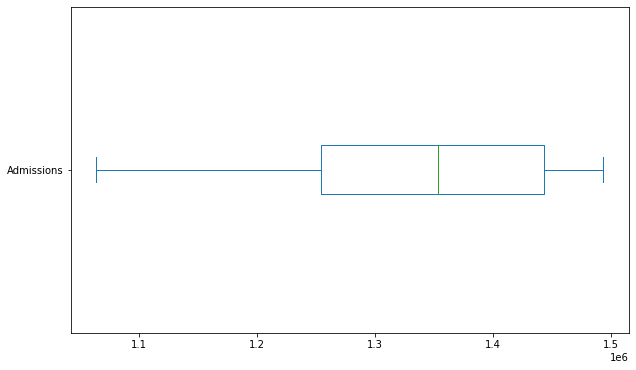

In [82]:
# detecting outliers
df_dropped['Admissions'].plot(kind = 'box', vert = False)

### Inpatient activity over Years

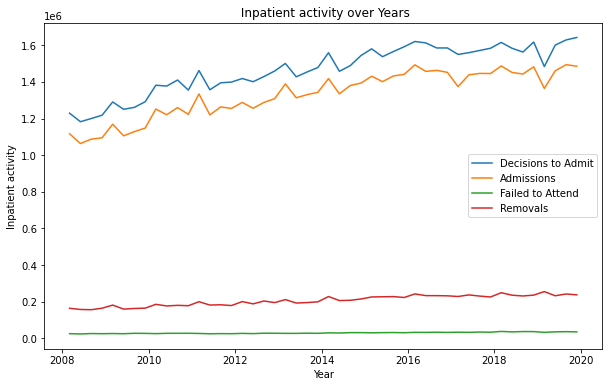

In [84]:
# plot the inpatient activity over years
plt.plot(df_dropped["Date"], df_dropped["Decisions to Admit"], label="Decisions to Admit")
plt.plot(df_dropped["Date"], df_dropped["Admissions"], label="Admissions")
plt.plot(df_dropped["Date"], df_dropped["Failed to Attend"], label="Failed to Attend")
plt.plot(df_dropped["Date"], df_dropped["Removals"], label="Removals")
plt.title(" Inpatient activity over Years")
plt.xlabel("Year")
plt.ylabel("Inpatient activity")
plt.legend()

plt.show()